# AP-v9-5-Model training and testing

In [147]:
import re

import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import nltk

from typing import List

from torch.utils.data import TensorDataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from pymystem3 import Mystem

Loading dataset and write to pandas.Dataframe

In [148]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/full_data_lemm.csv')
df = df.drop(df.columns[[0]], axis = 1)
df.iloc[:,0]-=1
data = df.dropna()

print(data)

      num                                               text
0       0  заказывать четыре кресло салон сентябрь привоз...
1       0  вайбериз это бандитский организация заказывать...
2       0  добрый время сутки читать данный текст давний ...
3       0  приветствовать год активно заказывать wb разли...
4       0  добрый день сталкиваться платформа вайлдберис ...
...   ...                                                ...
4995    4  последний время время изоляция находить отличн...
4996    4  давно пользоваться услуга данный маркетплейс н...
4997    4  интернет магазин отличный пользоваться протяже...
4998    4  очень крутой сайт приложение открывать недавно...
4999    4  добрый день понимать ругать сервис минус наход...

[5000 rows x 2 columns]


In [149]:
max_words = 31887
cv = CountVectorizer(max_features=max_words)
sparse_matrix = cv.fit_transform(data['text']).toarray()
feature_names = cv.get_feature_names_out()
words = feature_names.tolist()

print(feature_names)
print(sparse_matrix.shape)

['acasta' 'acer' 'acoola' ... 'ячменный' 'ящик' 'ящикя']
(5000, 31887)


Spliting the dataset in the ratio train, test, val: 80,10,10

In [150]:
x_train, x_test, y_train, y_test = train_test_split(sparse_matrix, np.array(data['num']),test_size = 0.1, shuffle = True)
print(len(x_train))
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1/0.9, shuffle = True)
print(len(x_train))

4500
3999


Casting pd.array to tensor and creating TensorDataset and DataLoader

In [151]:
batch_size = 200
learning_rate = 0.01
epochs = 5

train_features = torch.Tensor(x_train)
train_targets = torch.Tensor(y_train)
val_features = torch.Tensor(x_val)
val_targets = torch.Tensor(y_val)
test_features = torch.Tensor(x_test)
test_targets = torch.Tensor(y_test)

train = TensorDataset(train_features, train_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

Creating a LogisticRegression class

In [152]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(31887, 1000)
        self.linear2 = nn.Linear(1000, 100)
        self.linear3 = nn.Linear(100, 5)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [153]:
model = LogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters() , lr=learning_rate)

In [131]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/models/model-b1000-lr0001-e10.pt"))

<All keys matched successfully>

Train loop

In [154]:
model.train()
losses = []
for epoch in range(epochs):
  loss_values = []
  for x_batch, y_batch in train_loader:
    optimizer.zero_grad()
    y_pred = model(x_batch)
    loss = criterion(y_pred, y_batch.long())
    loss_values.append(loss.item())
    pred = torch.max(y_pred, 1)[1].eq(y_batch).sum()
    acc = pred * 100.0 / len(x_batch)
    loss.backward() #градиент текущего тензора
    optimizer.step()
  losses.append(np.array(loss_values).mean())
  print('Epoch: {}, Loss: {}, Accuracy: {}%'.format(epoch+1, losses[-1], acc.numpy()))

Epoch: 1, Loss: 1.3747578978538513, Accuracy: 49.74874496459961%
Epoch: 2, Loss: 0.7373016983270645, Accuracy: 75.87939453125%
Epoch: 3, Loss: 0.24359095022082328, Accuracy: 90.95477294921875%
Epoch: 4, Loss: 0.07279306910932064, Accuracy: 97.98995208740234%
Epoch: 5, Loss: 0.01142207479570061, Accuracy: 98.9949722290039%


Loss Value test vs Epochs plot

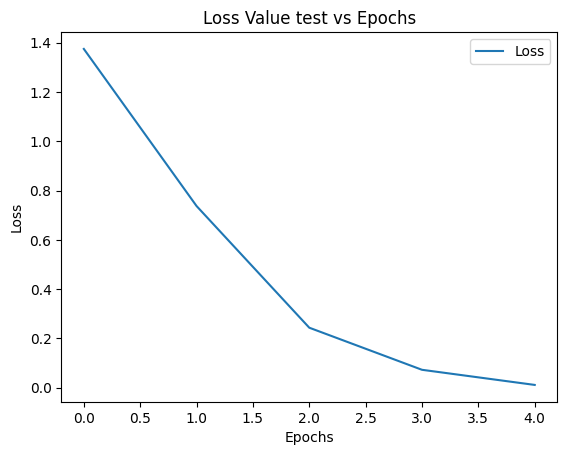

In [155]:
plt.plot(losses)
plt.title('Loss Value test vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss'])
plt.show()

Validation loss plot

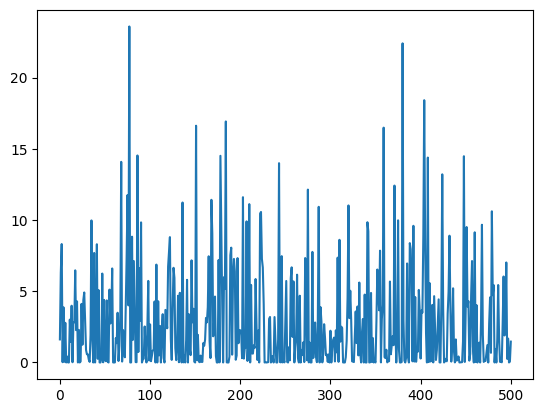

In [156]:
model.eval()
val_loss_list = []
with torch.no_grad():
  for i in range(len(val_features)):
    y_pred = model(val_features[i])
    loss = criterion(y_pred, val_targets[i].long())
    val_loss_list.append(loss)
plt.plot(val_loss_list)

Сhecking the model on a validation set

In [157]:
model.eval()
with torch.no_grad():
    y_pred = model(val_features)
    loss = criterion(y_pred, val_targets.long())
    pred = torch.max(y_pred, 1)[1].eq(val_targets).sum()
    print ("Accuracy : {}%".format(100*pred/len(test_features)))

Accuracy : 42.400001525878906%


Cheking the model on random feedback from original dataset

In [158]:
test_1 = cv.fit_transform(data['text']).toarray()
model.eval()
with torch.no_grad():
    y_pred = model(torch.Tensor(test_1[4105]))
    print(y_pred)

tensor([-24.2649, -29.6689,  -0.0922, -12.1232,  52.0150])


In [159]:
print(type(x_val[10]))
count = 0
for text in sparse_matrix:
  if np.array_equal(x_val[10], text):
    print(text)
    print(count)
    break
  else:
    count+=1

print(data.iloc[count])
model.eval()
with torch.no_grad():
  y_pred = model(torch.Tensor(x_val[10]))
  print(y_pred)


<class 'numpy.ndarray'>
[0 0 0 ... 0 0 0]
543
num                                                     0
text    купить платье както данный интернет магазин ра...
Name: 543, dtype: object
tensor([ 17.5194,   6.0419,  -5.6884, -14.1160, -24.4197])


Saving the model

In [123]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/models/model-b1000-lr0001-e10.pt")

Functions for creating your own vector from random feedback

In [141]:
def text_update(text: str) -> List[str]:
    """Function remove from text punctuation marks and split it

    Args:
        text (str): text for update

    Returns:
        List[str]: List with words from text
    """
    text = re.sub(r"[^\w\s]", "", text)
    text = text.split()
    return ' '.join(text)

def preprocess_text(text: str) -> List[str]:
    """Function gets text, lemmatize them and removes stopwords

    Args:
        text (str): text for preprocess

    Returns:
        List[str]: preprocessed text
    """
    mystem = Mystem()
    nltk.download('stopwords')
    russian_stopwords = stopwords.words("russian")
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords]
    text = " ".join(tokens)
    return text.split()

def my_vect(text:str)->List[float]:
  """function vectorizes text

    Args:
        text (str): text for loading into the model

    Returns:
        List[float]: List of words values
    """
  tensor = 31887*[0]
  text = preprocess_text(text_update(text))
  for word in set(text):
    if word in words:
      tensor[words.index(word)] = text.count(word)
  return tensor

Function for checking the model against random feedback

In [136]:
def predict(text: str)->torch.Tensor:
  """_summary_The function converts the text into a tensor and loads it into the model for testing

  Args:
      text (str): text for testing

  Returns:
      torch.Tensor: tensor of predictions
  """
  model.eval()
  with torch.no_grad():
    y_pred = model(torch.Tensor(my_vect(text)))
    print(type(y_pred))
    return(y_pred)

print(predict('Время от времени пользуемся услугами этого интернет магазина, особенно было актуально в период, лакдаун когда все магазины были закрыты. А одежда и обувь была нужна. Как раз на помощь пришёл магазин Wildberries. Но и до всяких корона вирусов мы ей пользовались.'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<class 'torch.Tensor'>
tensor([ 0.6547,  1.4441, -1.0223, -3.5154,  1.7123])
